<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/tree/main/Work_in_progress/cids_and_sids_from_pubchem_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectives
* Build binary classification models that predict activity/inactivity of small molecules against human aromatase using supervised learning methods.
* Evaluate the performance of the developed models using performance measures.

# Imports

In [1]:
! pip install rdkit --quiet
! pip install pysmiles --quiet
!pip install karateclub --quiet
!pip install git+https://github.com/samoturk/mol2vec --quiet
!pip install colour

     |████████████████████████████████| 36.8 MB 1.3 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 1.8 MB 18.9 MB/s 
     |████████████████████████████████| 24.1 MB 2.3 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 8.6 MB/s 


In [2]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from karateclub import Graph2Vec


In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from pylab import rcParams

In [4]:
import pandas as pd
import requests
import numpy as np
import time
import io
import rdkit
import networkx
import networkx as nx
import sklearn 
from io import StringIO
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
plt.rcParams['figure.figsize'] = [7.5,3]

In [48]:
from sklearn.naive_bayes import BernoulliNB        #-- Naive Bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier    #-- Decision Tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import (precision_recall_curve,
                            PrecisionRecallDisplay)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from pandas.io.sql import PandasSQL
from sklearn.base import BaseEstimator, TransformerMixin
from numpy.random import randint
import inspect
from sklearn.model_selection import GridSearchCV



#Load targets and *features*

## Load data from PubChem

Data is available at:https://pubchem.ncbi.nlm.nih.gov/bioassay/1345084

## Helper Functions for download, preprocessing, smiles conversion and reports

In [6]:
def load_csv_data_from_a_PubChem_assay(assay_id):
    #url = f'https://pubchem.ncbi.nlm.nih.gov/assay/pcget.cgi?query=download&record_type=datatable&actvty=all&response_type=save&aid={assay_id}'
    url=f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{assay_id}/concise/csv'
    #df_raw=pd.read_csv(url)
    df_raw=pd.read_csv(url)
    #print(df_raw.head())
    return(df_raw)

def drop_sids_with_no_cids(df):
    df = df.dropna( subset=['cid'] )
    #Remove CIDs with conflicting activities
    cid_conflict = []
    idx_conflict = []

    for mycid in df['cid'].unique() :
        
        outcomes = df[ df.cid == mycid ].activity.unique()
        
        if len(outcomes) > 1 :
            
            idx_tmp = df.index[ df.cid == mycid ].tolist()
            idx_conflict.extend(idx_tmp)
            cid_conflict.append(mycid)

    #print("#", len(cid_conflict), "CIDs with conflicting activities [associated with", len(idx_conflict), "rows (SIDs).]")
    df = df.drop(idx_conflict)

    #Remove redundant data

    df = df.drop_duplicates(subset='cid')  # remove duplicate rows except for the first occurring row.
    #print(len(df['sid'].unique()))
    #print(len(df['cid'].unique()))
    return df
    
     

def download_smiles_given_cids_from_pubmed(list_of_cids,chunk_size = 200): #returns df of smiles and cids
    df_smiles = pd.DataFrame()

    num_cids = len(list_of_cids)
    list_dfs = []
    if num_cids % chunk_size == 0 :
        num_chunks = int( num_cids / chunk_size )
    else :
        num_chunks = int( num_cids / chunk_size ) + 1

    #print("# CIDs = ", num_cids)
    #print("# CID Chunks = ", num_chunks, "(chunked by ", chunk_size, ")")

    for i in range(0, num_chunks) :
        idx1 = chunk_size * i
        idx2 = chunk_size * (i + 1)
        cidstr = ",".join( str(x) for x in list_of_cids[idx1:idx2] )

        url = ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cidstr + '/property/IsomericSMILES/TXT')
        res = requests.get(url)
        data = pd.read_csv( StringIO(res.text), header=None, names=['smiles'] )
        list_dfs.append(data)
        
        time.sleep(0.2)
        
        #if ( i % 5 == 0 ) :
            #print("Processing Chunk ", i)
    df_smiles = pd.concat(list_dfs,ignore_index=True)
    df_smiles[ 'cid' ] = list_of_cids   

    return df_smiles


def get_report(clf, y_true, y_pred,X):
    CMat = confusion_matrix( y_true, y_pred)

    acc  = accuracy_score( y_true, y_pred )
    
    sens = CMat[ 1 ][ 1 ] / ( CMat[ 1 ][ 0 ] + CMat[ 1 ][ 1 ] )    # TP / (FN + TP)
    spec = CMat[ 0 ][ 0 ] / ( CMat[ 0 ][ 0 ] + CMat[ 0 ][ 1 ] )    # TN / (TN + FP )
    bacc = (sens + spec) / 2

    y_score = clf.predict_proba( X )[:, 1]
    auc = roc_auc_score( y_true, y_score )

    print("#-- Accuracy          = ", acc)
    print("#-- Balanced Accuracy = ", bacc)
    print("#-- Sensitivity       = ", sens)
    print("#-- Specificity       = ", spec)
    print("#-- AUC-ROC           = ", auc)
    #print(CMat)
    print( classification_report(y_true, y_pred))
    ax = plt.gca()
    RocCurveDisplay.from_estimator(clf, X, y_true,ax=ax, alpha=0.8)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()
    disp = ConfusionMatrixDisplay(confusion_matrix=CMat,
                             display_labels=clf.classes_)
    disp.plot()
    plt.show()

## Get smiles and their associated activity targets

In [54]:

def load_smiles_and_activity_targets_from_a_PubChem_assay(assay_id):
    df_raw=load_csv_data_from_a_PubChem_assay(assay_id=assay_id)
    print(len(df_raw))
    #Drop substances without Inconclusive activity
    df_raw=df_raw[df_raw['Activity Outcome']!='Inconclusive']
    #Select active/inactive compounds for model building
    df=df_raw[ (df_raw['Activity Outcome'] == 'Active' ) | 
             (df_raw['Activity Outcome'] == 'Inactive' ) ].rename(columns={"CID": "cid", "SID":"sid","Activity Outcome": "activity"})
    #drop duplicates, and comnflicting activities, and substances with no cids
    df=drop_sids_with_no_cids(df)
    #label encoding
    df['activity'] = [ 0 if x == 'Inactive' else 1 for x in df['activity'] ]
    df_smiles=download_smiles_given_cids_from_pubmed(df.cid.astype(int).tolist())
    X=df_smiles.smiles.tolist()
    y=df.activity.astype(int).tolist()
    return(X,y)
X,y=load_smiles_and_activity_targets_from_a_PubChem_assay(1345084)
X,y=np.array(X),np.array(y)

61706


In [55]:
len(X), len(y)

(6660, 6660)

##This section executed only if working directly with Pipelines

###Downsampling

In [56]:
# Indicies of each class' observations
idx_inactives = np.where( y == 0 )[0]

idx_actives   = np.where(y == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)

# Join together downsampled inactives with actives
X = np.vstack((X[idx_inactives_downsampled], X[idx_actives]))
X=np.concatenate((X[0], X[1]), axis=None)
y = np.hstack((y[idx_inactives_downsampled], y[idx_actives]))
#X,y=np.array(X),np.array(y)

print("# inactives : ", len(y) - y.sum())
print("# actives   : ", y.sum())
print(len(X), len(y))



# inactives :  338
# actives   :  338
676 676


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))
print(np.sum(y_train), np.sum(y_test))


(540,) (136,)
540 136
270 68


In [58]:
print("# inactives : ", len(y_train) - np.sum(y_train))
print("# actives   : ", np.sum(y_train))

# inactives :  270
# actives   :  270


###Train-Test-Split

#MACCS EMBEDDINGS

##Create a function to convert smiles to macccs

In [99]:
def generate_maccs_keys_from_smiles_and_cids(smiles): #takes a list of smiles and returns df of cids and associated mac
    list_of_maccs=[]

    for idx, row in enumerate(smiles):
  
        mol = Chem.MolFromSmiles(row)
        
        if mol == None :
            print("Can't generate MOL object:", idx)
            list_of_maccs.append('None')
        else:
            list_of_maccs.append(list(MACCSkeys.GenMACCSKeys(mol).ToBitString()))

    return(list_of_maccs)
    

In [ ]:
X=generate_maccs_keys_from_smiles_and_cids(X)

## Reset the targets and labels using zip:)

In [785]:
#merge activity data and maccs keys
list1=[[i,j] for i,j in  zip(X,y) if i!='None' ]
X,y=list(zip(*list1))
X,y=np.array(X), np.array(y)
len(X),len(y)


(6666, 6666)

##Remove the maccs key with 0 variance

In [776]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
X=sel.fit_transform(X)
X.shape  #- After removal

(6666, 160)

##Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))
print(np.sum(y_train), np.sum(y_test))

##Downsampling

In [ ]:

# Indicies of each class' observations
idx_inactives = np.where( y_train == 0 )[0]
idx_actives   = np.where( y_train == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)

# Join together downsampled inactives with actives
X_train = np.vstack((X_train[idx_inactives_downsampled], X_train[idx_actives]))
y_train = np.hstack((y_train[idx_inactives_downsampled], y_train[idx_actives]))

print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())
print(len(y_train))
print(len(X_train))
print(len(X_train[0]))

##Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit( X_train ,y_train )
y_true, y_pred = y_train, clf.predict( X_train )
y_true1, y_pred1 = y_test, clf.predict( X_test )


#-- Accuracy          =  0.8586497890295358
#-- Balanced Accuracy =  0.8586497890295359
#-- Sensitivity       =  0.8523206751054853
#-- Specificity       =  0.8649789029535865
#-- AUC-ROC           =  0.9350531431928644
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       237
           1       0.86      0.85      0.86       237

    accuracy                           0.86       474
   macro avg       0.86      0.86      0.86       474
weighted avg       0.86      0.86      0.86       474



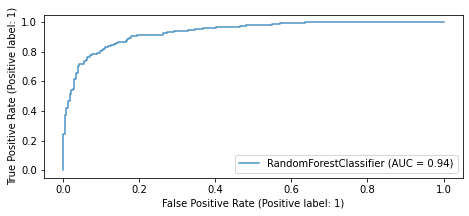

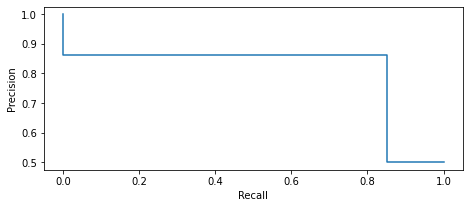

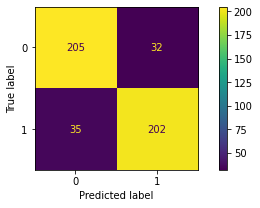

In [ ]:
get_report( clf, y_true, y_pred, X_train)

#-- Accuracy          =  0.7345
#-- Balanced Accuracy =  0.7289480132847408
#-- Sensitivity       =  0.7227722772277227
#-- Specificity       =  0.7351237493417588
#-- AUC-ROC           =  0.7986120886970213
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1899
           1       0.13      0.72      0.22       101

    accuracy                           0.73      2000
   macro avg       0.55      0.73      0.53      2000
weighted avg       0.94      0.73      0.81      2000



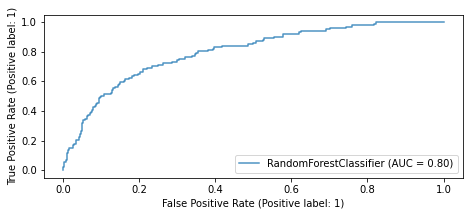

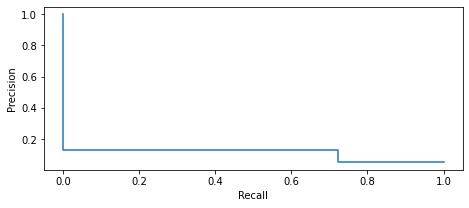

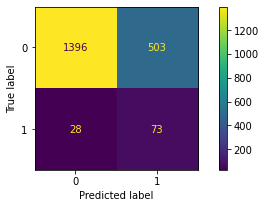

In [ ]:
get_report( clf,y_true1, y_pred1, X_test)

##Grid Search CV for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
scores = [ 'roc_auc', 'balanced_accuracy' ]

ncvs = 10

max_depth_range         = np.linspace( 3, 7, num=5, dtype='int32' )
n_estimators  = np.linspace( 10, 300, num=5, dtype='int32' )
criterion  = ["gini", "entropy", "log_loss"]

param_grid = dict( max_depth=max_depth_range,
                   n_estimators=n_estimators,
                   criterion=criterion )

clf = GridSearchCV( RandomForestClassifier( random_state=0 ),
                    param_grid=param_grid, cv=ncvs, scoring=scores, refit='roc_auc',
                    return_train_score = True)

In [ ]:
clf.fit( X_train, y_train )
print("Best parameter set", clf.best_params_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/p

Best parameter set {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 227}


In [ ]:
means_1a = clf.cv_results_['mean_train_roc_auc']
stds_1a  = clf.cv_results_['std_train_roc_auc']

means_1b = clf.cv_results_['mean_test_roc_auc']
stds_1b  = clf.cv_results_['std_test_roc_auc']

means_2a = clf.cv_results_['mean_train_balanced_accuracy']
stds_2a  = clf.cv_results_['std_train_balanced_accuracy']

means_2b = clf.cv_results_['mean_test_balanced_accuracy']
stds_2b  = clf.cv_results_['std_test_balanced_accuracy']

iterobjs = zip( means_1a, stds_1a, means_1b, stds_1b,
                means_2a, stds_2a, means_2b, stds_2b, clf.cv_results_['params'] )

for m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b, params in iterobjs :

    print( "Grid %r : %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f"
           % ( params, m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b))

Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 10} : 0.8214 0.0124 0.7537 0.0605 0.7475 0.0177 0.6962 0.0678
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 82} : 0.8406 0.0067 0.7755 0.0515 0.7677 0.0163 0.7049 0.0484
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 155} : 0.8421 0.0059 0.7784 0.0529 0.7731 0.0118 0.7027 0.0462
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 227} : 0.8427 0.0052 0.7769 0.0507 0.7750 0.0109 0.7090 0.0390
Grid {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 300} : 0.8425 0.0049 0.7758 0.0514 0.7726 0.0128 0.7048 0.0319
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 10} : 0.8732 0.0089 0.7747 0.0605 0.7937 0.0135 0.7024 0.0729
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 82} : 0.8925 0.0040 0.7833 0.0546 0.8080 0.0070 0.7155 0.0503
Grid {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 155} : 0.8948 0.0045 0.7940 0.0483 0.8139 0.0072 0.7088 0.0571
Grid {'criterion': 'gini', '

In [ ]:
clf0 = RandomForestClassifier(criterion='gini', max_depth=7, n_estimators= 227)
clf0.fit( X_train ,y_train )
y_true, y_pred = y_test, clf0.predict( X_test )

#-- Accuracy          =  0.7345
#-- Balanced Accuracy =  0.7289480132847408
#-- Sensitivity       =  0.7227722772277227
#-- Specificity       =  0.7351237493417588
#-- AUC-ROC           =  0.8184609930187331
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1899
           1       0.13      0.72      0.22       101

    accuracy                           0.73      2000
   macro avg       0.55      0.73      0.53      2000
weighted avg       0.94      0.73      0.81      2000



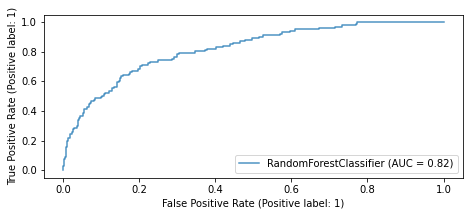

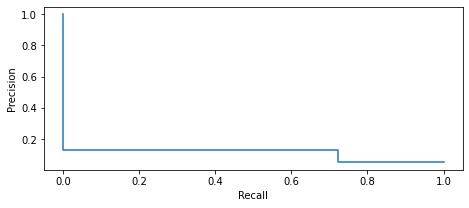

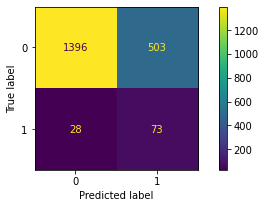

In [ ]:
get_report( clf0,y_true, y_pred, X_test)

##Pipeline I (only works if we can gnerate the MACCS keys for each training point, the transformers do not allow passing changed targets as argument in between sequences)

https://stackoverflow.com/questions/34727463/scikit-learn-custom-transformer-pipeline-that-changes-x-and-y

In [ ]:


class SmitoMACCS(BaseEstimator, TransformerMixin):


    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X=generate_maccs_keys_from_smiles_and_cids(X) #takes a df and returns df of cids and associated mac
        if any(a == 'None' for a in X):
          return None
        return np.array(X)
         


In [ ]:
inspect.getmembers(TransformerMixin, lambda a:not(inspect.isroutine(a)))

[('__class__', type),
 ('__dict__',
  mappingproxy({'__module__': 'sklearn.base',
                '__doc__': 'Mixin class for all transformers in scikit-learn.',
                'fit_transform': <function sklearn.base.TransformerMixin.fit_transform(self, X, y=None, **fit_params)>,
                '__dict__': <attribute '__dict__' of 'TransformerMixin' objects>,
                '__weakref__': <attribute '__weakref__' of 'TransformerMixin' objects>})),
 ('__doc__', 'Mixin class for all transformers in scikit-learn.'),
 ('__module__', 'sklearn.base'),
 ('__weakref__', <attribute '__weakref__' of 'TransformerMixin' objects>)]

In [ ]:
clf0 = RandomForestClassifier(criterion='gini', max_depth=7, n_estimators= 227)
pipe = Pipeline([('scaler', SmitoMACCS()), ('rf', clf0)])
#pipe = Pipeline([('scaler', SmitoMACCS())])

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.3)

In [ ]:
result=pipe.fit(X_train,y_train)

In [761]:
result.score(X_test, y_test)

0.9495

# Graph Embeddings

In [100]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                  bond_type=str(bond.GetBondType())[0:])
        
    return G

In [101]:

def list_of_smiles_to_list_of_graph_molecules(list_of_smiles):
   list_of_molecules=[Chem.MolFromSmiles(smiles) for smiles in list_of_smiles] 
   print(len(list_of_molecules),len(list_of_smiles ))
   i=0
   list_of_graph_molecules=[]
   for mol in list_of_molecules:
      try:
          list_of_graph_molecules.append(mol_to_nx(mol))
          i=i+1
      except:
          print(i)
          list_of_graph_molecules.append('None')
          i=i+1
   return list_of_graph_molecules


In [102]:
X_graphs=list_of_smiles_to_list_of_graph_molecules(X)


676 676


In [103]:
def reset_tragets_features_when_conversion_error(X,y):
    X=list_of_smiles_to_list_of_graph_molecules(X)
    list1=[[i,j] for i,j in  zip(X,y) if i!='None' ]
    X,y=list(zip(*list1))
    X,y=np.array(X), np.array(y)
    return X,y

In [104]:
X,y=reset_tragets_features_when_conversion_error(X,y)

676 676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


##Graph Coloring

In [923]:

def Hex_color(bond_type):
    random.seed( np.sum([ord(c) for c in bond_type]) -30+ ord(bond_type[0]))
    L = '0123456789ABCDEF'
    x= Color('#'+ ''.join([random.choice(L) for i in range(6)][:]))
    return x.get_hex()

def get_edge_color_list(mol_nx):
    edge_color=[ Hex_color(data[2]) for data in mol_nx.edges(data = 'bond_type')] 
    #print(edge_color)
    return edge_color

def return_colors_for_atoms(mol_nx):
    random.seed(767)

    color_map = {}
 
    for idx in mol_nx.nodes():
      if mol_nx.nodes[idx]['atom_symbol'] not in color_map:
         
          color_map[mol_nx.nodes[idx]['atom_symbol']] ="#%06x" % random.randint(sum([ord(c) for c in mol_nx.nodes[idx]['atom_symbol']]), 0xFFFFFF) 

    mol_colors = []
    for idx in mol_nx.nodes():
        if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
            mol_colors.append(color_map[mol_nx.nodes[idx]['atom_symbol']])
        else:
            mol_colors.append('gray')
    return mol_colors

def get_labels(mol_nx):
    return nx.get_node_attributes(mol_nx, 'atom_symbol')
#set(nx.get_node_attributes(mol_nx, 'atom_symbol').values())
#colors=[i/len(mol_nx.nodes) for i in range(len(mol_nx.nodes))]

def draw_one_mol(G, ax=None):
    
    #rcParams['figure.figsize'] = 25,30
    #color_lookup = {k:v for v, k in enumerate(sorted((nx.get_node_attributes(G, "atom_symbol"))))}
    selected_data = dict( (n, ord(d['atom_symbol'][0])**3 ) for n,d in G.nodes().items() )
    selected_data=[v[1] for k, v in enumerate(selected_data.items())]
    low, *_, high = sorted(selected_data)
    pos = nx.nx_pydot.graphviz_layout(G)


    nx.draw_networkx_nodes(G, pos,
          #labels= get_labels(G),
            node_size=100,
            #edgecolors='black',
            cmap='tab20c_r',
            vmin=low,
            vmax=high,
            node_color=[selected_data],
            ax=ax)
    networkx.draw_networkx_labels(G,pos, get_labels(G),ax=ax)
    nx.draw_networkx_edges(G, pos,
          #labels= get_labels(G),
            width=3,
            edge_color=get_edge_color_list(G),
            ax=ax)
    #nx.draw_networkx_edge_labels(G, pos, get_edge_labels(G), font_size=4,alpha=0.8,verticalalignment='bottom',
                                #horizontalalignment='center',clip_on='True',rotate='True' )
   

    

def get_edge_labels(G):
  return nx.get_edge_attributes(G,'bond_type')
  
def get_adjency_matrix(mol_nx):
    # print out the adjacency matrix ---------------------------------------------- 
    matrix = nx.to_numpy_matrix(mol_nx)
    print(matrix)
    return matrix

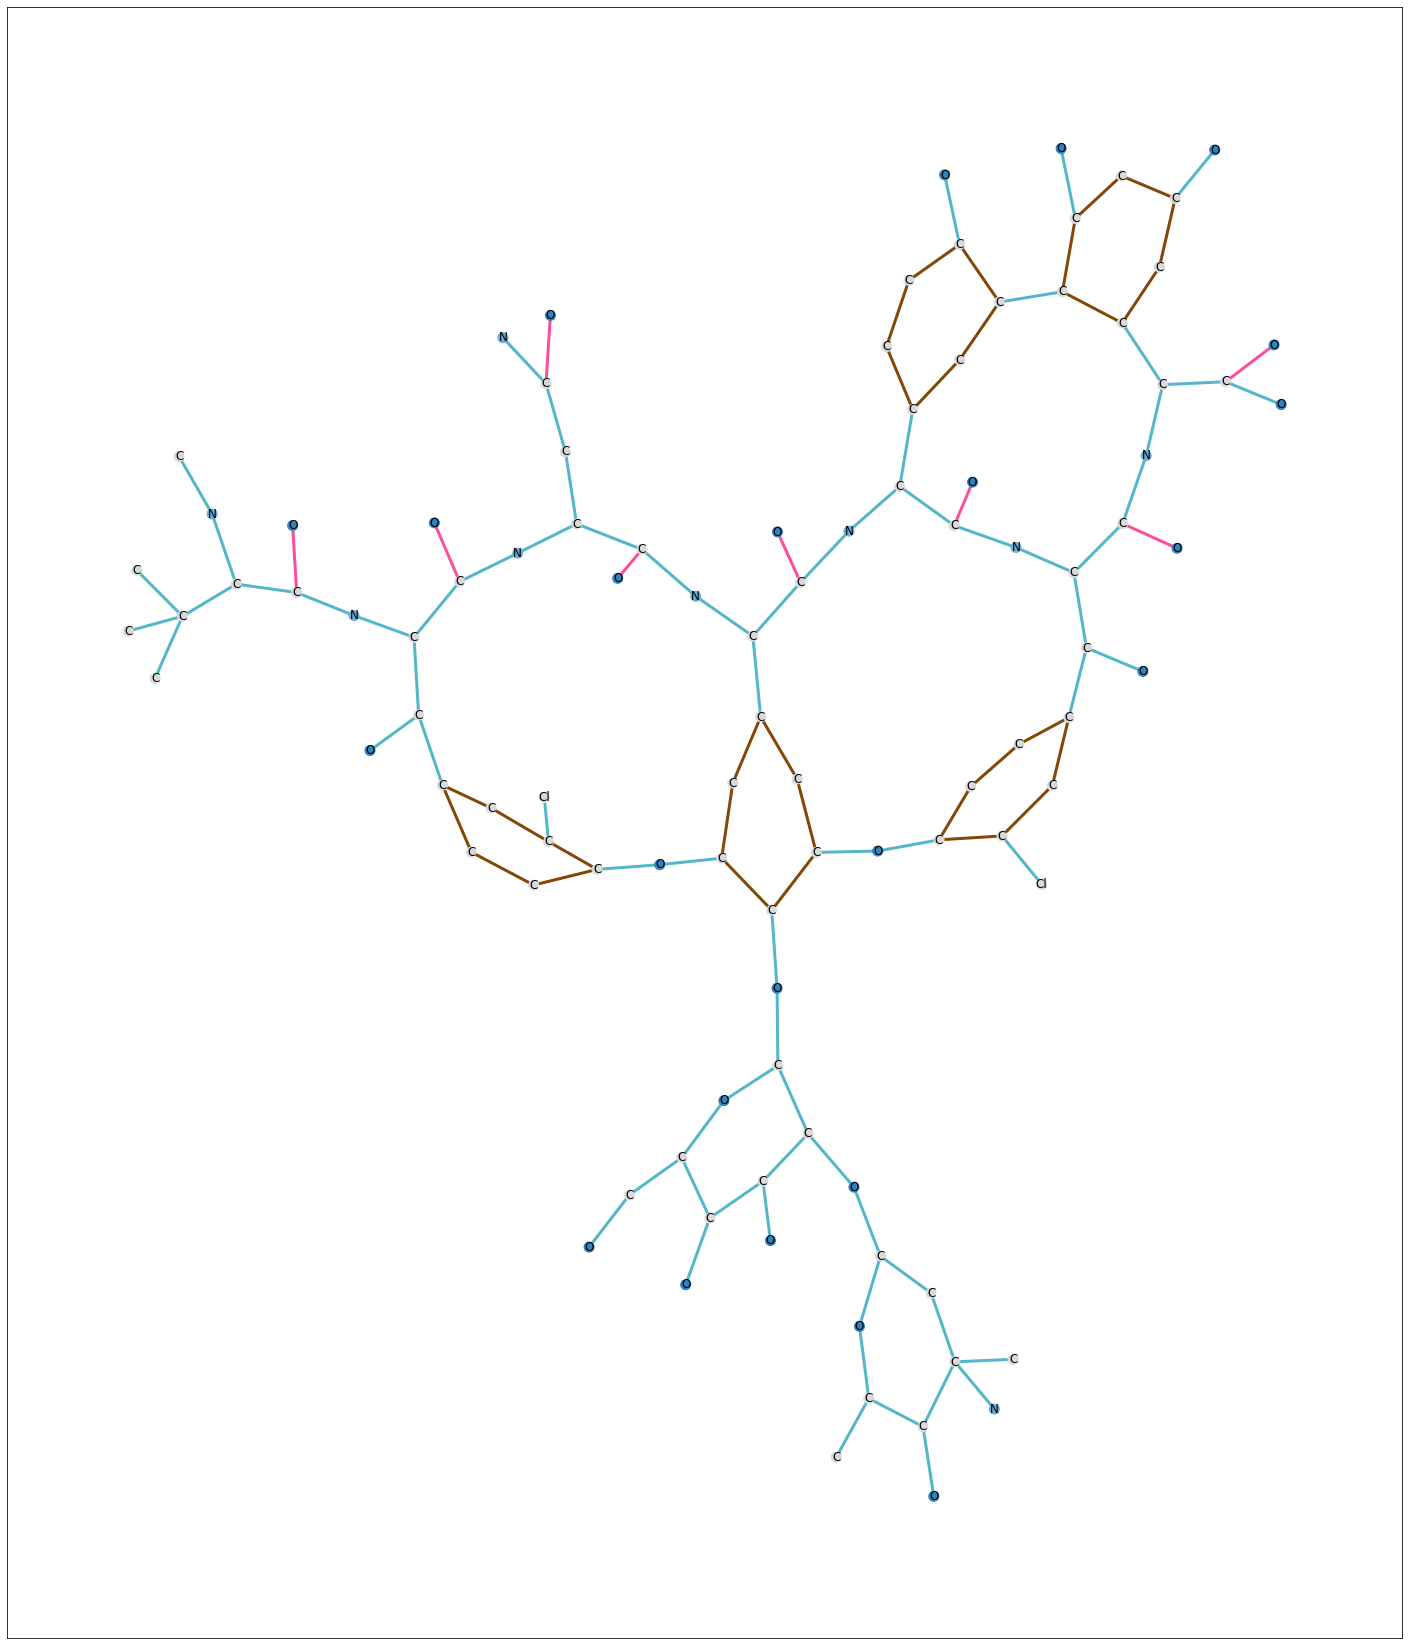

In [882]:
G=X_graphs[13]
draw_one_mol(G)

In [659]:

 
getRandomCol('sdw')

'#903df'

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)

In [118]:
 nx.get_node_attributes(mel, 'atom_symbol')

{0: 'C',
 1: 'C',
 2: 'C',
 3: 'C',
 4: 'C',
 5: 'C',
 6: 'C',
 7: 'C',
 8: 'C',
 9: 'O',
 10: 'N',
 11: 'C',
 12: 'C',
 13: 'O'}

In [122]:
 for node1, node2, data in G.edges(data=True):
    print(data)

{'bond_type': 'AROMATIC'}
{'bond_type': 'AROMATIC'}
{'bond_type': 'AROMATIC'}
{'bond_type': 'AROMATIC'}
{'bond_type': 'AROMATIC'}
{'bond_type': 'SINGLE'}
{'bond_type': 'AROMATIC'}
{'bond_type': 'DOUBLE'}
{'bond_type': 'SINGLE'}
{'bond_type': 'DOUBLE'}
{'bond_type': 'SINGLE'}
{'bond_type': 'SINGLE'}
{'bond_type': 'SINGLE'}
{'bond_type': 'SINGLE'}


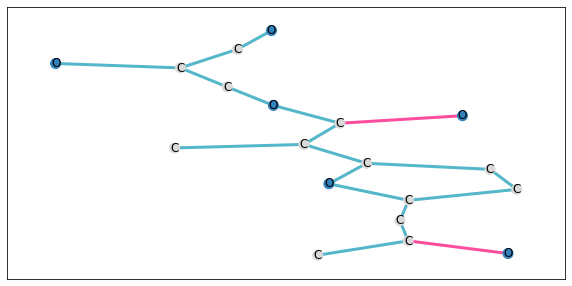

In [922]:
draw_one_mol(X_graphs[6])

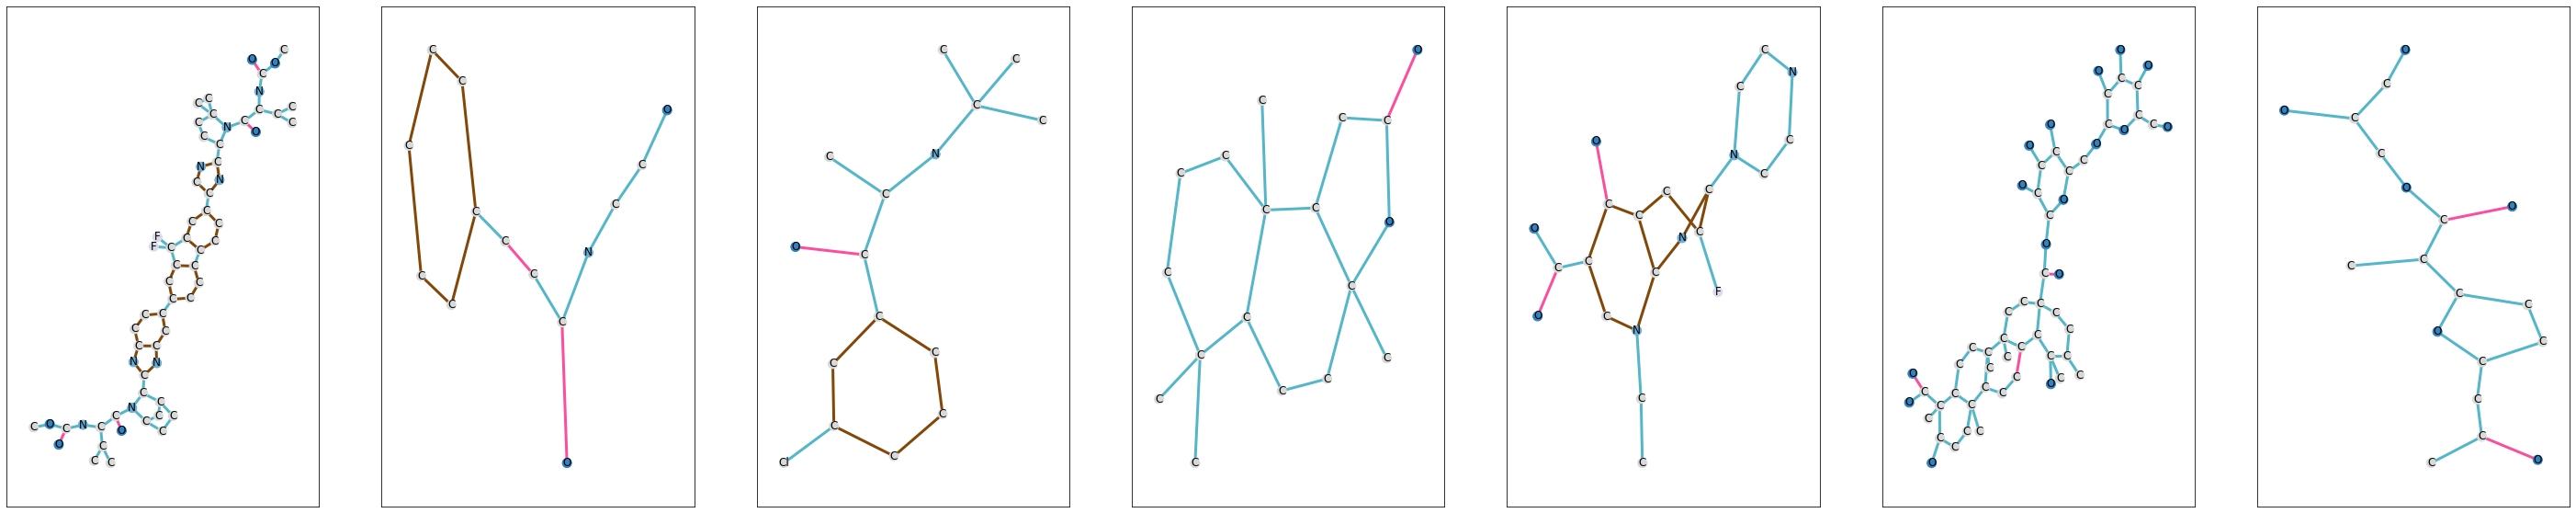

In [924]:
from operator import not_
def draw_graphs(list_of_graph_molecules, num_per_line=3,labels=None):
      ixs=[]
      num_per_line_ax_n=0
      if len(list_of_graph_molecules)%num_per_line==0:
       lines=int(len(list_of_graph_molecules)/num_per_line)
      else:
        lines=len(list_of_graph_molecules)//num_per_line+1
        num_per_line_ax_n=len(list_of_graph_molecules) % num_per_line
       
        for i in range(num_per_line-num_per_line_ax_n):
          ix=lines-1,num_per_line-i-1
          ixs.append(ix)
          
      #print(lines)
      fig, ax = plt.subplots(lines, num_per_line)
      fig.set_figheight(10)
      fig.set_figwidth(50)
      for i, mol_nx in enumerate(list_of_graph_molecules):
     
        ix = np.unravel_index(i, ax.shape)
        draw_one_mol(mol_nx, ax=ax[ix])
        if labels is not None:
            ax[ix].set_title(labels[i], fontsize=8)
      for ix in ixs:
           ax[ix].set_axis_off()
 
          
    
draw_graphs(X_graphs[:7], num_per_line=7)


##Graph2vec

In [26]:
model = Graph2Vec()
model.fit(np.array(X))

In [27]:
cid_graph2vec = model.get_embedding()
civ_graph2vec = pd.DataFrame(cid_graph2vec)
print(">>> civ_graph2vec shape = ", cid_graph2vec.shape)
print(civ_graph2vec)
print()

>>> civ_graph2vec shape =  (676, 128)
          0         1         2         3         4         5         6    \
0    0.046109 -0.066410 -0.056061  0.134822  0.008477 -0.026524 -0.017650   
1    0.033346 -0.049607 -0.052362  0.109842  0.016314 -0.019620 -0.012071   
2    0.062268 -0.103116 -0.094247  0.203663  0.028029 -0.037291 -0.017776   
3    0.078675 -0.136854 -0.115657  0.248398  0.021871 -0.040277 -0.023107   
4    0.042277 -0.071678 -0.063833  0.127115  0.015190 -0.020231 -0.010032   
..        ...       ...       ...       ...       ...       ...       ...   
671  0.066844 -0.100807 -0.084565  0.213777  0.028425 -0.039301 -0.015928   
672  0.056755 -0.113734 -0.089340  0.212233  0.022173 -0.031042 -0.021666   
673  0.036402 -0.073084 -0.068595  0.145221  0.020747 -0.025536 -0.008906   
674  0.032370 -0.056892 -0.054542  0.104898  0.013913 -0.013961 -0.008539   
675  0.057914 -0.110690 -0.091840  0.227553  0.031063 -0.038624 -0.020499   

          7         8         9    ..

89753.0

##Split data into targets and features


In [28]:
X=cid_graph2vec
print(X[:1], X.shape)
y[:1]

[[ 0.0461093  -0.06641009 -0.0560605   0.13482185  0.00847743 -0.02652417
  -0.01765046 -0.06924463 -0.0432445  -0.14673546 -0.05493447  0.07652016
  -0.10531951 -0.00655289 -0.07269381 -0.01562314 -0.01140397 -0.00726278
   0.05925312  0.06093886  0.00575555  0.03915071 -0.02229644  0.00693776
  -0.10683578 -0.01472958 -0.00081456 -0.1238637  -0.03451855  0.01182632
  -0.04016189 -0.02369381  0.04481534  0.09570011 -0.07996189  0.04604606
   0.00169459 -0.03449138  0.03717446 -0.06125185  0.0262739  -0.07005554
  -0.02921074  0.04011188  0.0050464  -0.00722132 -0.00613382  0.07332445
   0.02451387 -0.0234953   0.01497156 -0.04725266  0.02739041 -0.08519458
   0.03848472  0.02750491  0.08144414  0.08539414  0.00878131  0.02576238
   0.00543064  0.06378963  0.11299744  0.08239612  0.04768554  0.10367565
  -0.00728471  0.03671734  0.10936341  0.00219776  0.01841969 -0.05701134
  -0.00159983 -0.03748561  0.06887303 -0.09266601 -0.01905485  0.0179629
  -0.06713863  0.04754452 -0.02747164 -

array([0])

##Train_test_split

In [39]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(540, 128) (136, 128) (540,) (136,)
270 68


In [30]:
print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())

# inactives :  270
# actives   :  270


##Downsampling

In [40]:
# Indicies of each class' observations
idx_inactives = np.where( y_train == 0 )[0]
idx_actives   = np.where( y_train == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)
# Join together downsampled inactives with actives
X_train = np.vstack((X_train[idx_inactives_downsampled], X_train[idx_actives]))
y_train = np.hstack((y_train[idx_inactives_downsampled], y_train[idx_actives]))

In [41]:

print("# inactives : ", len(y_train) - y_train.sum())
print("# actives   : ", y_train.sum())
print(len(y_train))
print(len(X_train))
print(len(X_train[0]))

# inactives :  270
# actives   :  270
540
540
128


##Random Forest

In [42]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit( X_train ,y_train )
y_true, y_pred = y_train, clf.predict( X_train )
y_true1, y_pred1 = y_test, clf.predict( X_test )

#-- Accuracy          =  0.9851851851851852
#-- Balanced Accuracy =  0.9851851851851852
#-- Sensitivity       =  0.9962962962962963
#-- Specificity       =  0.9740740740740741
#-- AUC-ROC           =  0.9991769547325102
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       270
           1       0.97      1.00      0.99       270

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



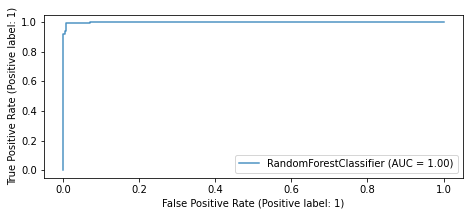

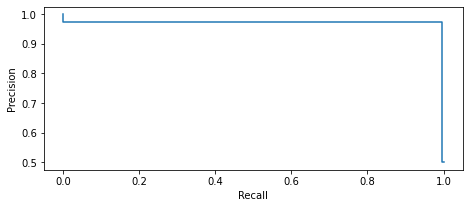

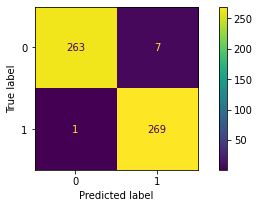

In [43]:
get_report( clf, y_true, y_pred, X_train)


#-- Accuracy          =  0.47058823529411764
#-- Balanced Accuracy =  0.47058823529411764
#-- Sensitivity       =  0.4264705882352941
#-- Specificity       =  0.5147058823529411
#-- AUC-ROC           =  0.4749134948096886
              precision    recall  f1-score   support

           0       0.47      0.51      0.49        68
           1       0.47      0.43      0.45        68

    accuracy                           0.47       136
   macro avg       0.47      0.47      0.47       136
weighted avg       0.47      0.47      0.47       136



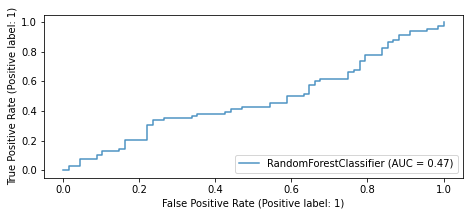

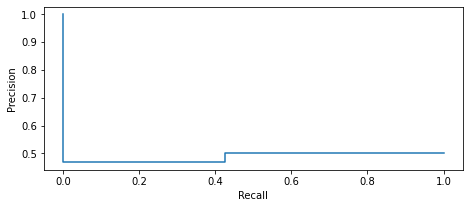

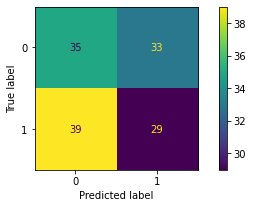

In [44]:
get_report( clf,y_true1, y_pred1, X_test)





##Grid Search(takes about 30 minutes to run)

In [49]:
scores = [ 'roc_auc', 'balanced_accuracy' ]

ncvs = 10

max_depth_range         = np.linspace( 3, 15, num=5, dtype='int32' )
n_estimators  = np.linspace( 10, 500, num=5, dtype='int32' )
criterion  = ["gini", "entropy"]

param_grid = dict( max_depth=max_depth_range,
                   n_estimators=n_estimators,
                   criterion=criterion )

clf = GridSearchCV( RandomForestClassifier( random_state=0 ),
                    param_grid=param_grid, cv=ncvs, scoring=scores, refit='roc_auc',
                    return_train_score = True)

In [ ]:

clf.fit( X_train, y_train )
print("Best parameter set", clf.best_params_)

In [ ]:
means_1a = clf.cv_results_['mean_train_roc_auc']
stds_1a  = clf.cv_results_['std_train_roc_auc']

means_1b = clf.cv_results_['mean_test_roc_auc']
stds_1b  = clf.cv_results_['std_test_roc_auc']

means_2a = clf.cv_results_['mean_train_balanced_accuracy']
stds_2a  = clf.cv_results_['std_train_balanced_accuracy']

means_2b = clf.cv_results_['mean_test_balanced_accuracy']
stds_2b  = clf.cv_results_['std_test_balanced_accuracy']

iterobjs = zip( means_1a, stds_1a, means_1b, stds_1b,
                means_2a, stds_2a, means_2b, stds_2b, clf.cv_results_['params'] )

for m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b, params in iterobjs :

    print( "Grid %r : %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f"
           % ( params, m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b))

In [ ]:
clf7 = RandomForestClassifier(criterion= 'gini', max_depth= 15, n_estimators= 132)
clf7.fit( X_train ,y_train )
y_true, y_pred = y_train, clf.predict( X_train )
y_true1, y_pred1 = y_test, clf.predict( X_test )

In [ ]:
get_report( clf, y_true, y_pred, X_train)


In [ ]:
get_report( clf,y_true1, y_pred1, X_test)


## Pipelines

### Smiles=> RDFkit Mol=> Nx Graph

In [66]:
class SmitoNxGraphs(BaseEstimator, TransformerMixin):


    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X=list_of_smiles_to_list_of_graph_molecules(X)
        if any(a == 'None' for a in X):
          return None
          print('Error')
        else: return np.array(X)

###  NXGraphs=> Graph2Vec

In [75]:
class NxGraphstoGraoh2Vec(BaseEstimator, TransformerMixin):


    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
       model = Graph2Vec()
       model.fit(np.array(X))
       X = model.get_embedding()
       return np.array(X)

In [96]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
pipe = Pipeline([('graphicalizer', SmitoNxGraphs()), ('vectorizer', NxGraphstoGraoh2Vec()), ('clf', clf)])


In [97]:
result=pipe.fit(X_train,y_train)


540 540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [98]:
result.score(X_test, y_test)


136 136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


0.5220588235294118